In [1]:
#training data: https://drive.google.com/file/d/1tFcqMUKtGb9iVIosf2U-VuFL_JOdOVNL/view?usp=sharing
#test data: https://drive.google.com/file/d/1ZR9g5x8yQ5aBEyEqTM50OM06AOsJwQzL/view?usp=sharing

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [3]:
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

train= pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train["Embarked"] = train["Embarked"].fillna("S")

def embark(df):
    if df == "S" :
        return 0
    elif df == "C" :
        return 1
    else:
        return 2
    
train["Embarked"]=train["Embarked"].apply(embark)
test["Embarked"]=test["Embarked"].apply(embark)

In [5]:
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())
train["Sex"]=pd.get_dummies(train["Sex"])
test['Sex']=pd.get_dummies(test['Sex'])

In [6]:
test.Fare[152] = test.Fare.median()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
# there is some titles to consider such as Dr, Master, Rev
train['title']=0
train["title"][train["Name"].str.contains('Dr')] = 1
train["title"][train["Name"].str.contains('Master')]= 2
train["title"][train["Name"].str.contains('Rev')]= 3

test['title']=0
test["title"][test["Name"].str.contains('Dr')] = 1
test["title"][test["Name"].str.contains('Master')]= 2
test["title"][test["Name"].str.contains('Rev')]= 3

#Name Length
train['name_length']=train['Name'].str.len()
test['name_length']=test['Name'].str.len()

train['age^2']=train['Age']**2
test['age^2']=train['Age']**2

train['fare^2']=train['Fare']**2
test['fare^2']=train['Fare']**2

train['ralatives']=train['SibSp']+train['Parch']
test['ralatives']=test['SibSp']+test['Parch']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [8]:
title_dummy_train=pd.get_dummies(train['title'])
title_dummy_train.columns=['others','Dr','Master','Rev']
title_dummy_test=pd.get_dummies(test['title'])
title_dummy_test.columns=['others','Dr','Master','Rev']

train = pd.concat([train, title_dummy_train],axis=1)
test = pd.concat([test, title_dummy_test],axis=1)

In [9]:
#Death
a=pd.crosstab(train['title'],train['Survived'])
a['total']=a[0]+a[1]
a['ratio']=(a[1]/(a['total']))*100
a

Survived,0,1,total,ratio
title,,,,
0,521,313,834,37.529976
1,5,6,11,54.545455
2,17,23,40,57.500000
3,6,0,6,0.000000


In [10]:
a=train['Ticket'].str[:5]
a.sort_values(ascending=False, inplace=True)
a=a[:230]
a.value_counts()

PC 17    60
C.A.     27
STON/    18
SOTON    17
W./C.     9
CA. 2     8
A/5.      7
A/5 2     6
CA 21     6
SC/PA     5
F.C.C     5
S.O.C     5
SC/Pa     4
LINE      4
A/5 3     4
A/4 4     3
SC/AH     3
S.O./     3
C 707     3
S.C./     3
A/4.      3
WE/P      2
P/PP      2
A.5.      2
PP 95     2
A./5.     2
C.A./     1
S.O.P     1
W.E.P     1
A4. 5     1
PP 43     1
W/C 1     1
Fa 26     1
S.W./     1
SCO/W     1
S.P.      1
A/S 2     1
SW/PP     1
SO/C      1
SC 17     1
F.C.      1
C 173     1
C 400     1
Name: Ticket, dtype: int64

In [11]:
train['ticke_initial']=0
train["ticke_initial"][train["Ticket"].str.startswith('P')]= 1
train["ticke_initial"][train["Ticket"].str.startswith('C')]= 2
train["ticke_initial"][train["Ticket"].str.startswith('W')]= 3
train["ticke_initial"][train["Ticket"].str.startswith('A')]= 4
train["ticke_initial"][train["Ticket"].str.startswith('F')]= 5
train["ticke_initial"][train["Ticket"].str.startswith('L')]= 6
train["ticke_initial"][train["Ticket"].str.contains('STON')]= 7
train["ticke_initial"][train["Ticket"].str.contains('SOTON')]= 7
train["ticke_initial"][train["Ticket"].str.contains('S')]= 8


test['ticke_initial']=0
test["ticke_initial"][test["Ticket"].str.startswith('P')]= 1
test["ticke_initial"][test["Ticket"].str.startswith('C')]= 2
test["ticke_initial"][test["Ticket"].str.startswith('W')]= 3
test["ticke_initial"][test["Ticket"].str.startswith('A')]= 4
test["ticke_initial"][test["Ticket"].str.startswith('F')]= 5
test["ticke_initial"][test["Ticket"].str.startswith('L')]= 6
test["ticke_initial"][test["Ticket"].str.contains('STON')]= 7
test["ticke_initial"][test["Ticket"].str.contains('SOTON')]= 7
test["ticke_initial"][test["Ticket"].str.contains('S')]= 8


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [12]:
a=pd.crosstab(train["ticke_initial"],train['Survived'])
a['total']=a[0]+a[1]
a['ratio']=(a[1]/(a['total']))*100
a

Survived,0,1,total,ratio
ticke_initial,,,,
0,407,254,661,38.426626
1,23,42,65,64.615385
2,30,16,46,34.782609
3,11,2,13,15.384615
4,26,2,28,7.142857
5,3,4,7,57.142857
6,3,1,4,25.000000
8,46,21,67,31.343284


In [13]:
b=train['Cabin'].dropna()
b.sort_values(ascending=True, inplace=True)
b=b.value_counts()
c=train['Cabin'].str.count(" ")

In [14]:
#A~G and T
train["Cabin"] = train["Cabin"].fillna('Z')
train['cabin_letter']=0
train['cabin_letter'][train["Cabin"].str.startswith("A")]= 1
train['cabin_letter'][train["Cabin"].str.startswith('B')]= 2
train['cabin_letter'][train["Cabin"].str.startswith('C')]= 3
train['cabin_letter'][train["Cabin"].str.startswith('D')]= 4
train['cabin_letter'][train["Cabin"].str.startswith('E')]= 5
train['cabin_letter'][train["Cabin"].str.startswith('F')]= 6
train['cabin_letter'][train["Cabin"].str.startswith('G')]= 7
train['cabin_letter'][train["Cabin"].str.startswith('T')]= 8

test["Cabin"] = test["Cabin"].fillna('Z')
test['cabin_letter']=0
test['cabin_letter'][test["Cabin"].str.startswith("A")]= 1
test['cabin_letter'][test["Cabin"].str.startswith('B')]= 2
test['cabin_letter'][test["Cabin"].str.startswith('C')]= 3
test['cabin_letter'][test["Cabin"].str.startswith('D')]= 4
test['cabin_letter'][test["Cabin"].str.startswith('E')]= 5
test['cabin_letter'][test["Cabin"].str.startswith('F')]= 6
test['cabin_letter'][test["Cabin"].str.startswith('G')]= 7
test['cabin_letter'][test["Cabin"].str.startswith('T')]= 8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: Se

In [15]:
test['cabin_letter'].value_counts()

0    327
3     35
2     18
4     13
5      9
6      8
1      7
7      1
Name: cabin_letter, dtype: int64

In [16]:
#Death
a=pd.crosstab(train['cabin_letter'],train['Survived'])
a['total']=a[0]+a[1]
a['ratio']=(a[1]/(a['total']))*100
a

Survived,0,1,total,ratio
cabin_letter,,,,
0,481,206,687,29.985444
1,8,7,15,46.666667
2,12,35,47,74.468085
3,24,35,59,59.322034
4,8,25,33,75.757576
5,8,24,32,75.000000
6,5,8,13,61.538462
7,2,2,4,50.000000
8,1,0,1,0.000000


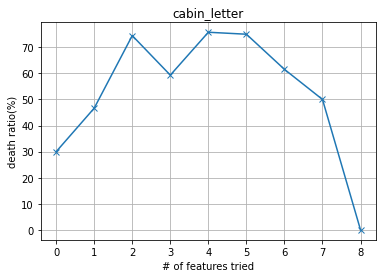

In [17]:
a['ratio'].plot(kind="line", marker='x')
plt.title("cabin_letter")
plt.xlabel("# of features tried")
plt.ylabel("death ratio(%)")
plt.grid(True)

In [18]:
#Multiple cabin
train['cabin_#']=0
train['cabin_#'][train["Cabin"]=="Z"]= 0
train['cabin_#'][(train["Cabin"].str.count(" ")==0) & (train["Cabin"]!="Z")]= 1
train['cabin_#'][train["Cabin"].str.count(" ")==1]= 2
train['cabin_#'][train["Cabin"].str.count(" ")==2]= 3
train['cabin_#'][train["Cabin"].str.count(" ")==3]= 4

test['cabin_#']=0
test['cabin_#'][test["Cabin"]=="Z"]= 0
test['cabin_#'][(test["Cabin"].str.count(" ")==0) & (test["Cabin"]!="Z")]= 1
test['cabin_#'][test["Cabin"].str.count(" ")==1]= 2
test['cabin_#'][test["Cabin"].str.count(" ")==2]= 3
test['cabin_#'][test["Cabin"].str.count(" ")==3]= 4

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [19]:
train['Age_bin'] = pd.qcut(train['Age'].rank(method='first'), 10, labels=False)
test['Age_bin'] = pd.qcut(test['Age'].rank(method='first'), 10, labels=False)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,fare^2,ralatives,others,Dr,Master,Rev,ticke_initial,cabin_letter,cabin_#,Age_bin
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,...,52.562500,1,1,0,0,0,4,0,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,...,5081.308859,1,1,0,0,0,1,3,1,7
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,...,62.805625,0,1,0,0,0,8,0,0,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,...,2819.610000,1,1,0,0,0,0,3,1,7
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,...,64.802500,0,1,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,...,169.000000,0,0,0,0,1,0,0,0,3
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,...,900.000000,0,1,0,0,0,0,2,1,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,28.0,1,2,W./C. 6607,23.4500,...,549.902500,3,1,0,0,0,3,0,0,6
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,...,900.000000,0,1,0,0,0,0,3,1,3


In [20]:
train['Fare_bin'] = pd.qcut(train['Fare'], 10, labels=False)
test['Fare_bin'] = pd.qcut(test['Fare'], 10, labels=False)
a=pd.crosstab(train['Fare_bin'],train['Survived'])
a['total']=a[0]+a[1]
a['ratio']=(a[1]/(a['total']))*100
a

Survived,0,1,total,ratio
Fare_bin,,,,
0,79,13,92,14.130435
1,61,26,87,29.885057
2,87,19,106,17.924528
3,60,18,78,23.076923
4,48,36,84,42.857143
5,51,37,88,42.045455
6,43,46,89,51.685393
7,57,34,91,37.362637
8,42,47,89,52.808989


In [21]:
a=pd.crosstab(train['Age_bin'],train['Survived'])
a['total']=a[0]+a[1]
a['ratio']=(a[1]/(a['total']))*100
a

Survived,0,1,total,ratio
Age_bin,,,,
0,38,52,90,57.777778
1,59,30,89,33.707865
2,58,31,89,34.831461
3,51,38,89,42.696629
4,59,30,89,33.707865
5,71,18,89,20.224719
6,53,36,89,40.449438
7,48,41,89,46.067416
8,60,29,89,32.584270


In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

y = train["Survived"]
X =train[["Pclass", "Sex", "Age","SibSp","Parch", "Fare","Embarked","ralatives","ticke_initial","cabin_letter","cabin_#"]]
X_test = test[["Pclass", "Sex", "Age","SibSp","Parch", "Fare","Embarked","ralatives","ticke_initial","cabin_letter","cabin_#"]]
rfclf = RandomForestClassifier(n_estimators = 10, max_features=8, max_leaf_nodes=5, random_state = 42)
'''
rfclf.fit(X, y)
predictions=rfclf.predict(X_test)
print(rfclf.predict(X_test))
rfclf.fit(X, y)
predictions=rfclf.predict(X_test)
print(rfclf.predict(X_test))
'''

'\nrfclf.fit(X, y)\npredictions=rfclf.predict(X_test)\nprint(rfclf.predict(X_test))\nrfclf.fit(X, y)\npredictions=rfclf.predict(X_test)\nprint(rfclf.predict(X_test))\n'

In [23]:
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc, accuracy_score
skf = StratifiedKFold(n_splits=3,shuffle=True)

srf_pred_test_full = 0
cv_accuracy = []
df_feature_importance = []
i= 1
for train_index, validation_index in skf.split(X,y):
  print('{} of KFold {}'.format(i,skf.n_splits))
  X_train, X_val = X.loc[train_index], X.loc[validation_index]
  y_train, y_val = y.loc[train_index], y.loc[validation_index]

  rf = RandomForestClassifier(n_estimators = 10, max_features=8, max_leaf_nodes=5, random_state = 42)
  rf.fit(X_train,y_train)
  accuracy = accuracy_score(y_val,rf.predict(X_val))
  print('Accuracy Score:', accuracy)
  cv_accuracy.append(accuracy)
  srf_test_pred = rf.predict(X_test)
  srf_pred_test_full += srf_test_pred
  df_feature_importance.append(rf.feature_importances_)
  i+=1

  print('\n')
  print(np.mean(cv_accuracy))
    
    

1 of KFold 3
Accuracy Score: 0.8080808080808081


0.8080808080808081
2 of KFold 3
Accuracy Score: 0.8013468013468014


0.8047138047138047
3 of KFold 3
Accuracy Score: 0.8047138047138047


0.8047138047138048


In [24]:
y_pred = srf_pred_test_full/3
submit = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':y_pred})
submit['Survived'] = submit['Survived'].apply(lambda x: 1 if x>=0.5 else 0)
submit.to_csv('srf_3folds_titanic.csv',index=False)